<a href="https://colab.research.google.com/github/campu1992/Classification_Conversation_Chats-/blob/main/Train_model_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALACION DE DEPENDENCIAS**

In [1]:
!pip install transformers[torch]
!pip install accelerate -U

**IMPORTACION DE LIBRERIAS**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import re
import string
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import joblib

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**CARGA DEL DATASET**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Prediccion_clasificacion_chat/dataset_openai.md')

In [5]:
df.head()

,Producto,Conversación,Venta
0,Laptop HP,"Cliente: Hola, estoy buscando una laptop HP. \...",Venta
1,Smart TV Samsung,"Cliente: Hola, estoy buscando una Smart TV Sam...",No venta
2,Teléfono móvil iPhone 13,"Cliente: Hola, estoy interesado en el iPhone 1...",No venta
3,Tablet Samsung Galaxy Tab S7,"Cliente: Hola, estoy buscando una tablet Samsu...",No venta
4,Consola de videojuegos PlayStation 5,"Cliente: Hola, ¿tienen la PlayStation 5 dispon...",No venta


**LIMPIEZA DE DATOS**

In [6]:
df = df.drop_duplicates(subset='Producto')

In [7]:
df = df[df['Producto'] != 'Producto']

In [8]:
df["Venta"].replace(["No venta", "Venta"], [False,True], inplace=True)

In [9]:
def limpiar_texto(texto):
    texto_limpio = re.sub(r"[^a-zA-Z0-9]", " ", texto)
    return texto_limpio.lower().strip()

In [10]:
df['Conversacion'] = df['Conversación'].apply(limpiar_texto)

In [11]:
df["Categoria"] = "venta_de_producto_fisico" # Agregamos una columna con categoria de negocio

**EDA**

In [12]:
# Conteo de la distribución de negociaciones cerradas y no cerradas
print(df['Venta'].value_counts())

Venta
True     19
False    10
Name: count, dtype: int64


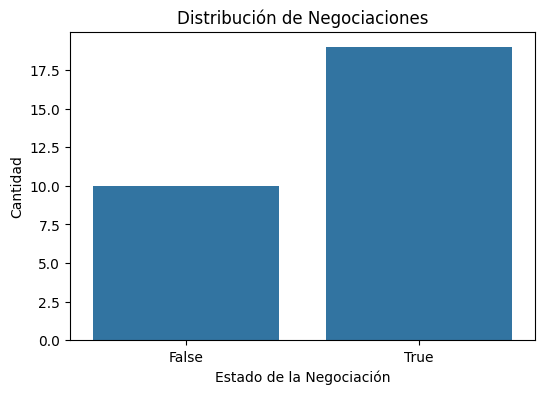

In [13]:
# Gráfico de barras para la distribución de negociaciones cerradas y no cerradas
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Venta')
plt.title('Distribución de Negociaciones')
plt.xlabel('Estado de la Negociación')
plt.ylabel('Cantidad')
plt.show()

count     29.000000
mean     189.000000
std       72.308367
min      129.000000
25%      150.000000
50%      159.000000
75%      186.000000
max      438.000000
Name: longitud_conversacion, dtype: float64


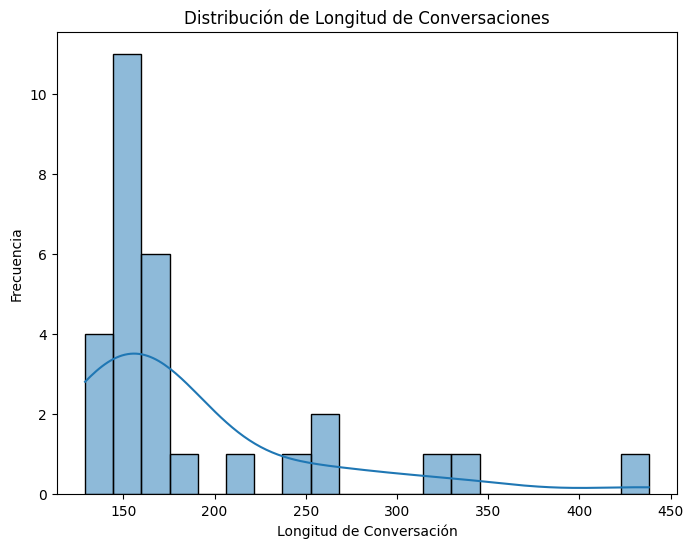

In [14]:
# Calcular la longitud de las conversaciones
df['longitud_conversacion'] = df['Conversación'].apply(lambda x: len(x.split()))

print(df['longitud_conversacion'].describe())

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='longitud_conversacion', bins=20, kde=True)
plt.title('Distribución de Longitud de Conversaciones')
plt.xlabel('Longitud de Conversación')
plt.ylabel('Frecuencia')
plt.show()


**OBSERVACIONES:** *Si el conjunto de datos de entrenamiento contiene principalmente conversaciones cortas, el modelo puede estar sesgado hacia este tipo de conversaciones y tener un peor rendimiento en la predicción de conversaciones más largas,La precisión, por ejemplo, puede no ser una buena métrica para conversaciones largas, ya que un pequeño error en la predicción de una conversación larga puede tener un gran impacto en la puntuación general, se realizara un submuestreo aleatorio de las conversaciones más largas para que la distribución de la longitud sea más uniforme.*

# DESARROLLO MODELO PREDICCION DE CIERRE DE NEGOCIO

**PREPROCESAMIENTO**

In [15]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text) # Tokenización
    stop_words = set(stopwords.words('spanish'))     # Eliminar stopwords y puntuaciones
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    lemmatizer = WordNetLemmatizer()     # Lematización
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    clean_text = ' '.join(tokens)
    return clean_text

In [16]:
df['Conversacion'] = df['Conversacion'].apply(preprocess_text)

X = df['Conversacion']
y = df['Venta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Submuestreo para balancear las clases
train_data = pd.concat([X_train, y_train], axis=1)
negociacion_cerrada = train_data[train_data['Venta'] == True]
negociacion_no_cerrada = train_data[train_data['Venta'] == False]

# Determinar el número de muestras en la clase minoritaria
min_samples = min(len(negociacion_cerrada), len(negociacion_no_cerrada))

# Realizar el submuestreo con el número de muestras en la clase minoritaria
negociacion_no_cerrada_downsampled = resample(negociacion_no_cerrada,
                                              replace=False,
                                              n_samples=min_samples,
                                              random_state=42)

# Combinar los datasets balanceados
train_data_balanced = pd.concat([negociacion_cerrada, negociacion_no_cerrada_downsampled])

**DEFINICION DE PIPELINE Y ENTRENAMIENTO DEL MODELO**

In [17]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear'))
])

model.fit(train_data_balanced['Conversacion'], train_data_balanced['Venta'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svm', SVC(kernel='linear'))])

**PREDICCIÓN Y CALCULO DE METRICAS**

In [22]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.8888888888888888
Precision: 0.8571428571428571
Recall: 1.0
F1 Score: 0.923076923076923
Confusion Matrix:
[[2 1]
 [0 6]]


**HIPERPARAMETRIZACION**

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC())
])

param_grid = {
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(train_data_balanced['Conversacion'], train_data_balanced['Venta'])

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Mejor puntuación de validación:", best_score)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Mejores hiperparámetros: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'tfidf__max_df': 0.9, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Mejor puntuación de validación: 1.0


**VALIDACIÓN CRUZADA**

In [20]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear'))
])

cv_scores = cross_val_score(model, X_train, y_train, cv=10) # Lo hacemos con 10 folds

print("Scores de Validación Cruzada:", cv_scores)

print("Promedio de Scores de Validación Cruzada:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Scores de Validación Cruzada: [1.  1.  1.  1.  1.  1.  1.  1.  0.5 1. ]
Promedio de Scores de Validación Cruzada: 0.95


In [21]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear'))
])

model.fit(train_data_balanced['Conversacion'], train_data_balanced['Venta'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svm', SVC(kernel='linear'))])

**EXPORTACIÓN DEL MODELO DE PREDICCION DE CIERRE DE NEGOCIO**

In [24]:
joblib.dump(model, '/content/drive/MyDrive/Prediccion_clasificacion_chat/modelo_chats.pkl')

['/content/drive/MyDrive/Prediccion_clasificacion_chat/modelo_chats.pkl']

**PRUEBA CON TEXTO COMO INPUT**

In [25]:
def predecir_negociacion(conversacion):
    preprocessed_conversacion = preprocess_text(conversacion)
    prediction = model.predict([preprocessed_conversacion])
    return bool(prediction[0])

conversacion_ejemplo = """Agente (Laura): ¡Hola! ¿En qué puedo ayudarte hoy?

Cliente (Carlos): Hola, estoy buscando un nuevo smartphone. Mi viejo ya está fallando y necesito uno con una buena cámara y batería duradera.

Agente (Laura): Entiendo, Carlos. Tenemos una amplia gama de smartphones. ¿Tienes alguna marca en mente o alguna característica específica que estés buscando además de una buena cámara y batería?

Cliente (Carlos): He escuchado cosas buenas sobre los modelos de Samsung. También quiero que tenga suficiente espacio de almacenamiento porque tomo muchas fotos y videos.

Agente (Laura): Perfecto, Samsung es una excelente elección. Te recomendaría el Samsung Galaxy S21. Tiene una cámara de 64MP, batería de 4000mAh y viene con 128GB de almacenamiento interno. ¿Qué te parece?

Cliente (Carlos): Suena bien. ¿Cuánto cuesta?

Agente (Laura): Actualmente, el Samsung Galaxy S21 está en oferta por $799. Además, ofrecemos financiación sin intereses si lo prefieres.

Cliente (Carlos): Eso suena genial. ¿Qué otros beneficios ofrece este modelo?

Agente (Laura): Además de la impresionante cámara y batería, el Galaxy S21 cuenta con un procesador muy rápido, pantalla de 6.2 pulgadas con resolución Full HD+ y es resistente al agua y al polvo. También incluye la posibilidad de expandir el almacenamiento con una tarjeta microSD.

Cliente (Carlos): Parece que es justo lo que estoy buscando. ¿Cómo funciona el proceso de financiación?

Agente (Laura): Es muy sencillo. Puedes elegir pagar en cuotas mensuales sin intereses durante 12 meses. Solo necesitas una tarjeta de crédito válida y completar una breve solicitud en línea.

Cliente (Carlos): Perfecto, me interesa la financiación. ¿Cómo podemos proceder?

Agente (Laura): ¡Excelente! Te enviaré un enlace para que completes la solicitud en línea. Una vez aprobada, te enviaremos el smartphone a tu domicilio sin costo adicional en un plazo de 3 a 5 días hábiles. ¿Te parece bien?

Cliente (Carlos): Sí, eso suena perfecto. Gracias por tu ayuda, Laura.

Agente (Laura): Es un placer, Carlos. Te enviaré el enlace de inmediato. ¿Puedes confirmar que recibiste el enlace y que todo está en orden?

Cliente (Carlos): Sí, acabo de recibirlo. Déjame completar la solicitud.

(Pausa mientras Carlos completa la solicitud)

Cliente (Carlos): Listo, ya envié la solicitud.

Agente (Laura): Perfecto, Carlos. Déjame verificar... Sí, tu solicitud ha sido aprobada. Hemos procesado tu pedido y el Samsung Galaxy S21 será enviado a tu dirección. Deberías recibirlo en 3 a 5 días hábiles.

Cliente (Carlos): ¡Genial! Muchas gracias, Laura. Estoy muy emocionado por recibir mi nuevo smartphone.

Agente (Laura): Me alegra escuchar eso, Carlos. Si necesitas algo más o tienes alguna pregunta, no dudes en contactarnos. ¡Que disfrutes tu nuevo teléfono!

Cliente (Carlos): Seguro, gracias de nuevo. ¡Hasta luego!

Agente (Laura): ¡Hasta luego, Carlos! Que tengas un excelente día."""
resultado = predecir_negociacion(conversacion_ejemplo)
print("¿La negociación fue cerrada exitosamente? : ", resultado)

¿La negociación fue cerrada exitosamente? :  True


# DESARROLLO MODELO CLASIFICACION TIPO DE NEGOCIO

**PREPROCESAMIENTO**

In [26]:
df['Conversacion'] = df['Conversacion'].apply(preprocess_text)
df['Categoria'] = df['Categoria'].apply(preprocess_text)


In [34]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Conversacion'], df['Categoria'], test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels_encoded)
val_dataset = CustomDataset(val_encodings, val_labels_encoded)

model = AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", num_labels=len(label_encoder.classes_))

# Establecer las gradientes en cero para congelar las capas anteriores excepto las últimas
for param in model.base_model.parameters():
    param.requires_grad = False

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**ENTRENAMIENTO DEL MODELO**

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.084017
2,No log,0.084005
3,No log,0.083982
4,No log,0.083948
5,No log,0.083902
6,No log,0.083844
7,No log,0.083776
8,No log,0.083695
9,No log,0.083604
10,0.118200,0.083501


TrainOutput(global_step=15, training_loss=0.11716945568720499, metrics={'train_runtime': 3.4254, 'train_samples_per_second': 100.719, 'train_steps_per_second': 4.379, 'total_flos': 22693124770560.0, 'train_loss': 0.11716945568720499, 'epoch': 15.0})

**DESCONGELAMIENTO DE LAS GRADIENTES Y RE-ENTRENAMIENTO AFINADO**

In [36]:
# Descongelar algunas capas y continuar entrenando
for param in model.base_model.encoder.layer[-6:].parameters():
    param.requires_grad = True

training_args.num_train_epochs = 10  # Ajustar número de épocas según necesidad

# Entrenar con más capas descongeladas
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.082816
2,No log,0.081449
3,No log,0.078763
4,No log,0.074832
5,No log,0.069753
6,No log,0.063672
7,No log,0.056776
8,No log,0.049265
9,No log,0.041389
10,0.099400,0.033440


TrainOutput(global_step=10, training_loss=0.09942707419395447, metrics={'train_runtime': 3.7313, 'train_samples_per_second': 61.642, 'train_steps_per_second': 2.68, 'total_flos': 15128749847040.0, 'train_loss': 0.09942707419395447, 'epoch': 10.0})

**GUARDAR MODELO**

In [44]:
model.save_pretrained('/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model')
tokenizer.save_pretrained('/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model')

('/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model/vocab.txt',
 '/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model/added_tokens.json',
 '/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model/tokenizer.json')

**PRUEBA DE MODELO DE CLASIFICACION DE CATEGORIA DE NEGOCIO**

In [38]:
df = df.drop("Categoria", axis=1)


In [39]:
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model') # Carga de nuestro modelo re-entrenado
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Prediccion_clasificacion_chat/fine_tuned_model')

In [40]:
# Crear pipeline de clasificación
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

In [41]:
labels = ["venta_de_producto_fisico","venta_de_servicio","venta_adicional","venta_cruzada","venta_de_suscripcion","renovacion_de_contrato","mejora_de_servicio","reduccion_de_servicio","soporte_tecnico","soporte_de_facturacion","procesamiento_de_reembolso","resolucion_de_quejas","solicitud_de_informacion","programacion_de_citas","recoleccion_de_feedback","gestion_de_cuentas","soporte_postventa","conversion_de_clientes_potenciales","recordatorio_de_renovacion","retencion_de_clientes"]

def classify_conversation(conversation):
    inputs = tokenizer(conversation, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    predicted_label = label_encoder.inverse_transform(np.array([predicted_class]))  # Convertir a array unidimensional
    return predicted_label[0]

df['Categoria'] = df['Conversacion'].apply(classify_conversation)

**PRUEBA CON UN EJEMPLO**

In [42]:
conversacion_ejemplo = """Agente: ¡Hola! Le escribimos para informarle que su dispositivo ya ha sido reparado y enviado de regreso a su dirección. Debería recibirlo en un plazo de 2 a 3 días hábiles.

Cliente: (Con tono más tranquilo) ¡Muchas gracias por su aviso! Me alegra saber que el problema se ha solucionado.

Agente: De nada. Nos alegra haber podido ayudarle. Esperamos que ahora pueda disfrutar de su dispositivo sin problemas.

Cliente: Eso espero. Por cierto, me gustaría disculparme por mi comportamiento anterior. Estaba un poco molesto porque el dispositivo no funcionaba y no me comuniqué de la mejor manera.

Agente: Agradezco su disculpa. Entendemos que a veces los clientes se frustran cuando tienen problemas con sus productos, y estamos aquí para ayudarlos de la mejor manera posible.

Cliente: Gracias por su comprensión. Valoro su paciencia y amabilidad.

Agente: De nada. Ha sido un placer atenderle. Si tiene alguna otra pregunta o necesita ayuda en el futuro, no dude en contactarnos.

Cliente: Lo haré. Gracias nuevamente por todo su apoyo.

Agente: ¡Hasta luego!
"""
categoria_ejemplo = classify_conversation(conversacion_ejemplo)
print("Categoría de la conversación:", categoria_ejemplo)

Categoría de la conversación: venta_de_producto_fisico


In [43]:
df.head(30)

,Producto,Conversación,Venta,Conversacion,longitud_conversacion,Categoria
0,Laptop HP,"Cliente: Hola, estoy buscando una laptop HP. \...",True,cliente hola buscando laptop hp vendedor hola ...,264,venta_de_producto_fisico
1,Smart TV Samsung,"Cliente: Hola, estoy buscando una Smart TV Sam...",False,cliente hola buscando smart tv samsung vendedo...,341,venta_de_producto_fisico
2,Teléfono móvil iPhone 13,"Cliente: Hola, estoy interesado en el iPhone 1...",False,cliente hola interesado iphone 13 vendedor hol...,260,venta_de_producto_fisico
3,Tablet Samsung Galaxy Tab S7,"Cliente: Hola, estoy buscando una tablet Samsu...",False,cliente hola buscando tablet samsung galaxy ta...,316,venta_de_producto_fisico
4,Consola de videojuegos PlayStation 5,"Cliente: Hola, ¿tienen la PlayStation 5 dispon...",False,cliente hola playstation 5 disponible vendedor...,251,venta_de_producto_fisico
5,Cámara Canon EOS Rebel T7,"Cliente: Hola, estoy interesado en la cámara C...",False,cliente hola interesado c mara canon eos rebel...,438,venta_de_producto_fisico
6,Refrigerador LG de doble puerta,"Cliente: Hola, estoy buscando un refrigerador ...",True,cliente hola buscando refrigerador doble puert...,154,venta_de_producto_fisico
7,Barra de sonido LG SN11RG,"Cliente: Hola, estoy buscando una barra de son...",False,cliente hola buscando barra sonido alta calida...,211,venta_de_producto_fisico
8,Portátil Asus ROG Zephyrus G14,"Cliente: Hola, estoy buscando un portátil para...",True,cliente hola buscando port til juegos recomend...,151,venta_de_producto_fisico
9,Auriculares Bose QuietComfort 45,"Cliente: Hola, estoy interesado en los auricul...",False,cliente hola interesado auriculare bose quietc...,175,venta_de_producto_fisico
